###Install Library

In [ ]:
!pip install -q torch
!pip install -q tf
!pip install -q gdown
!pip install -q "transformers[torch]" accelerate -U
!pip install -q -U accelerate
!pip install -q datasets
!pip install -q gensim
!pip install -q tensorflow
!pip install -q evaluate

### Import Library

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from collections import Counter
import tensorflow as tf
from gensim.models import Word2Vec
from transformers import AutoTokenizer, AutoModelForSequenceClassification,Trainer, AutoConfig, TrainingArguments, EarlyStoppingCallback
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Dense, Flatten, concatenate, BatchNormalization,LSTM, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from evaluate import load as load_metric
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import he_normal
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import BorderlineSMOTE,KMeansSMOTE,SVMSMOTE

###Read Dataset and load Word2Vec

In [ ]:
df = pd.read_csv("/content/news_train_balanced_clean.csv")

In [ ]:
df_test1 = pd.read_csv("/content/news_test_clean.csv")

In [ ]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
gc.collect()
print(gensim.__version__)
# Load Pretrained Word Embeddings (Word2Vec)
# !gdown --id 1QYj5FruufaPq2mZgC6lZlq2Uw2E004Og
# !gdown --id 1F9QsHO7FPIPq3nL_I0zCkZFvq3OVcJrB
# !gdown --id 1VUjxpH10baOw439V-YAAVVbtyI8iLgG5

4.4.0


In [ ]:
import os
import gdown
import zipfile

'''https://drive.google.com/file/d/1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3/view?usp=sharing'''

file_id = '1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3'

url = f'https://drive.google.com/uc?id={file_id}'
output_zip = 'model_w2v.zip'

if not os.path.exists('idwiki_word2vec_768_new_lower.model'):
    print("Downloading Model...")
    gdown.download(url, output_zip, quiet=False)

    print("Extracting File...")
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Done.")
else:
    print("Model Available")


Model Available


In [ ]:
word_embeddings = Word2Vec.load('/content/idwiki_word2vec_768_new_lower.model')

###Split Dataset

In [ ]:
x_train = df['Text']
y_train = df['Label']

In [ ]:
x_test1 = df_test1['Text']
y_test1 = np.array(df_test1['Label'])

###Define Loss Function, Tokenization, Word Embeddings and Oversampling

In [ ]:
# Define the margin loss function
def margin_loss(y_true, y_pred):
    margin = K.constant(0.1)
    y_true_float = K.cast(y_true, dtype='float32')  # Convert y_true to float32
    squared_difference_pos = K.square(K.maximum(0.9 - y_pred, 0))
    squared_difference_neg = K.square(K.maximum(y_pred - 0.1, 0))
    loss_pos = K.mean(y_true_float * squared_difference_pos)
    loss_neg = K.mean((1 - y_true_float) * squared_difference_neg)
    total_loss = loss_pos + lambda_val * loss_neg
    return total_loss

In [ ]:
# Define the model architectures
#embedding_dim = 300
#max_sequence_length = 100
lambda_val = 0.7  # Lambda value for margin loss
#num_words = 100000
max_sequence_length = 100 # Moving the definition of max_sequence_length here

In [ ]:
# Create word index
word_index = {word: index + 1 for index, word in enumerate(word_embeddings.wv.index_to_key)}

# Create embedding matrix
embedding_dim = word_embeddings.vector_size
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word_embeddings.wv:
        embedding_vector = word_embeddings.wv[word]
        embedding_matrix[i] = embedding_vector


In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words=len(word_index) + 1, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train.astype(str))

# Convert text to sequences and pad
x_train_sequences = tokenizer.texts_to_sequences(x_train.astype(str))
# Convert all values in x_test1 to string before tokenization
x_test_sequences1 = tokenizer.texts_to_sequences(x_test1.astype(str))

# Determine max sequence length based on your data
max_sequence_length = max(max(len(seq) for seq in x_train_sequences), max(len(seq) for seq in x_test_sequences1))

x_train_padded = pad_sequences(x_train_sequences, maxlen=max_sequence_length, padding='post')
x_test_padded1 = pad_sequences(x_test_sequences1, maxlen=max_sequence_length, padding='post')

In [ ]:
x_train_flat = x_train_padded.reshape(x_train_padded.shape[0], -1)

####Oversampling with BorderlineSMOTE

In [ ]:
borderline_smote = BorderlineSMOTE(random_state=42)
x_train_resampled_flat_borderline, y_train_resampled_borderline = borderline_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_borderline = x_train_resampled_flat_borderline.reshape(x_train_resampled_flat_borderline.shape[0], max_sequence_length)

####Oversampling with KMeansSMOTE

In [ ]:
kmeans_smote = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.2)
x_train_resampled_flat_kmeans, y_train_resampled_kmeans = kmeans_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_kmeans = x_train_resampled_flat_kmeans.reshape(x_train_resampled_flat_kmeans.shape[0], max_sequence_length)

####Oversampling with SVMSMOTE

In [ ]:
svm_smote = SVMSMOTE(random_state=42)
x_train_resampled_flat_svm, y_train_resampled_svm = svm_smote.fit_resample(x_train_flat, y_train)
x_train_resampled_svm = x_train_resampled_flat_svm.reshape(x_train_resampled_flat_svm.shape[0], max_sequence_length)

In [ ]:
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


##LSTM Model

In [ ]:
# Define the architecture of the static model with he_normal initialization
lstm_input = Input(shape=(max_sequence_length,))
lstm_embedding = Embedding(len(word_index) + 1, embedding_dim, input_length=max_sequence_length, trainable=False)(lstm_input)  # Removed weights parameter

# LSTM Layers
static_lstm_output = LSTM(128, kernel_initializer=he_normal())(lstm_embedding)  # Use he_normal initialization
static_lstm_output = Dropout(0.5)(static_lstm_output)
batch_norm_layer = BatchNormalization()(static_lstm_output)

# Fully Connected Layers
static_dense_output = Dense(128, activation='relu', kernel_initializer=he_normal())(batch_norm_layer)  # Use he_normal initialization
static_dense_output = Dropout(0.5)(static_dense_output)
output = Dense(1, activation='sigmoid')(static_dense_output)

# Create the static model
lstm_model = Model(inputs=lstm_input, outputs=output)
lstm_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


###LSTM BorderlineSMOTE Train and Test

In [ ]:
# Train the LSTM model
epochs_lstm = 10
history_lstm_borderline = lstm_model.fit(
    x_train_resampled_borderline,
    y_train_resampled_borderline,
    batch_size=128,
    epochs=epochs_lstm,
    validation_split=0.1,
)

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 61s 212ms/step - accuracy: 0.5004 - loss: 0.1847 - val_accuracy: 1.0000 - val_loss: 0.1419
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4855 - loss: 0.1388 - val_accuracy: 1.0000 - val_loss: 0.1515
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4702 - loss: 0.1343 - val_accuracy: 1.0000 - val_loss: 0.1551
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4710 - loss: 0.1333 - val_accuracy: 1.0000 - val_loss: 0.1508
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.4564 - loss: 0.1330 - val_accuracy: 1.0000 - val_loss: 0.1495
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4531 - loss: 0.1328 - val_accuracy: 1.0000 - val_loss: 0.1501
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4521 - loss: 0.1328 - val_accuracy: 1.0000 - val_loss: 0.1484
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4491 - loss: 0

####Cross-Validation Train

In [ ]:
from sklearn.model_selection import KFold
# Define the number of folds
num_folds = 10

# Initialize K-Fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # You can set a random seed for reproducibility

# Initialize lists to store cross-validation results
accuracies = []
losses = []

In [ ]:
# Convert the data to numpy arrays
x_train_np = np.array(x_train_resampled_borderline)
y_train_np = np.array(y_train_resampled_borderline)

In [ ]:
# Initialize lists to store training and validation accuracies and losses
train_accuracies_lstm = []
val_accuracies_lstm = []
train_losses_lstm = []
val_losses_lstm = []
classification_reports_lstm = []

# Iterate over the folds
fold = 0
for train_indices, val_indices in kf.split(x_train_np):
    fold += 1
    print(f"Training fold {fold}/{num_folds}")

    lstm_model = Model(inputs=lstm_input, outputs=output)

    lstm_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])
    # Get the training and validation data for this fold
    x_train_fold = x_train_np[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold = x_train_np[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Early stopping callback
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    # Train the model for this fold
    history = lstm_model.fit(
        x_train_fold,
        y_train_fold,
        batch_size=128,
        epochs=epochs_lstm,  # Make sure you define epochs_hybrid
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping],
    )

    # Evaluate the model on this fold for training and validation
    train_loss_lstm, train_accuracy_lstm = lstm_model.evaluate(x_train_fold, y_train_fold)
    val_loss_lstm, val_accuracy_lstm = lstm_model.evaluate(x_val_fold, y_val_fold)

    print(f"Fold {fold} - Training Loss: {train_loss_lstm}, Training Accuracy: {train_accuracy_lstm}")
    print(f"Fold {fold} - Validation Loss: {val_loss_lstm}, Validation Accuracy: {val_accuracy_lstm}")

    # Store the results for this fold
    train_accuracies_lstm.append(train_accuracy_lstm)
    val_accuracies_lstm.append(val_accuracy_lstm)
    train_losses_lstm.append(train_loss_lstm)
    val_losses_lstm.append(val_loss_lstm)

    # Evaluate the model
    y_pred = (lstm_model.predict(x_val_fold) > 0.5).astype("int32").flatten()

    # Generate and store the classification report
    report = classification_report(y_val_fold, y_pred, output_dict=True)
    classification_reports_lstm.append(report)

    # Print the classification report for this fold
    print(classification_report(y_val_fold, y_pred))
    print("-" * 60)

Training fold 1/10
Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 60s 220ms/step - accuracy: 0.5025 - loss: 0.1325 - val_accuracy: 0.5009 - val_loss: 0.1317
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5004 - loss: 0.1321 - val_accuracy: 0.5009 - val_loss: 0.1319
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4967 - loss: 0.1322 - val_accuracy: 0.5009 - val_loss: 0.1320
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 57s 213ms/step - accuracy: 0.5009 - loss: 0.1317 - val_accuracy: 0.5009 - val_loss: 0.1316
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4975 - loss: 0.1320 - val_accuracy: 0.5009 - val_loss: 0.1318
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5003 - loss: 0.1318 - val_accuracy: 0.5009 - val_loss: 0.1318
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5036 - loss: 0.1318 - val_accuracy: 0.5009 - val_loss: 0.1318
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.1782 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 60s 217ms/step - accuracy: 0.5017 - loss: 0.1318 - val_accuracy: 0.4980 - val_loss: 0.1320
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 57s 213ms/step - accuracy: 0.4998 - loss: 0.1319 - val_accuracy: 0.4980 - val_loss: 0.1319
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 57s 213ms/step - accuracy: 0.4936 - loss: 0.1321 - val_accuracy: 0.4980 - val_loss: 0.1318
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4997 - loss: 0.1318 - val_accuracy: 0.4980 - val_loss: 0.1318
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.5014 - loss: 0.1317 - val_accuracy: 0.4980 - val_loss: 0.1318
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.4986 - loss: 0.1318 - val_accuracy: 0.4980 - val_loss: 0.1318
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.1787 - loss: 0.1453
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1809 - loss: 0.1452
Fold 2 - Training Loss: 0.13169017434120178, Training Accur

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 60s 218ms/step - accuracy: 0.4983 - loss: 0.1320 - val_accuracy: 0.5068 - val_loss: 0.1315
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 57s 213ms/step - accuracy: 0.5003 - loss: 0.1318 - val_accuracy: 0.5068 - val_loss: 0.1315
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5017 - loss: 0.1317 - val_accuracy: 0.5068 - val_loss: 0.1315
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 57s 213ms/step - accuracy: 0.4970 - loss: 0.1318 - val_accuracy: 0.5068 - val_loss: 0.1314
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5001 - loss: 0.1317 - val_accuracy: 0.5068 - val_loss: 0.1314
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 57s 213ms/step - accuracy: 0.4963 - loss: 0.1319 - val_accuracy: 0.5068 - val_loss: 0.1313
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4975 - loss: 0.1318 - val_accuracy: 0.5068 - val_loss: 0.1314
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5000 - loss: 0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 60s 218ms/step - accuracy: 0.5022 - loss: 0.1316 - val_accuracy: 0.4879 - val_loss: 0.1323
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 57s 213ms/step - accuracy: 0.4947 - loss: 0.1320 - val_accuracy: 0.4879 - val_loss: 0.1323
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5019 - loss: 0.1316 - val_accuracy: 0.4879 - val_loss: 0.1323
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5016 - loss: 0.1317 - val_accuracy: 0.4879 - val_loss: 0.1324
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5005 - loss: 0.1317 - val_accuracy: 0.4879 - val_loss: 0.1323
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.1800 - loss: 0.1452
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1695 - loss: 0.1457
Fold 4 - Training Loss: 0.13163085281848907, Training Accuracy: 0.5013391971588135
Fold 4 - Validation Loss: 0.13228242099285126, Validation Accuracy: 0.487947016954422
118/118 ━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 60s 220ms/step - accuracy: 0.4997 - loss: 0.1317 - val_accuracy: 0.5062 - val_loss: 0.1314
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 57s 213ms/step - accuracy: 0.4962 - loss: 0.1319 - val_accuracy: 0.5062 - val_loss: 0.1314
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4996 - loss: 0.1318 - val_accuracy: 0.5062 - val_loss: 0.1314
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5017 - loss: 0.1316 - val_accuracy: 0.5062 - val_loss: 0.1314
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4977 - loss: 0.1318 - val_accuracy: 0.5062 - val_loss: 0.1314
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.1778 - loss: 0.1463
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1894 - loss: 0.1458
Fold 5 - Training Loss: 0.1317223757505417, Training Accuracy: 0.499308317899704
Fold 5 - Validation Loss: 0.1313970685005188, Validation Accuracy: 0.5062251687049866
118/118 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 60s 217ms/step - accuracy: 0.4972 - loss: 0.1318 - val_accuracy: 0.5097 - val_loss: 0.1313
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 57s 214ms/step - accuracy: 0.4977 - loss: 0.1318 - val_accuracy: 0.5097 - val_loss: 0.1313
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.5004 - loss: 0.1317 - val_accuracy: 0.5097 - val_loss: 0.1313
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5018 - loss: 0.1317 - val_accuracy: 0.5097 - val_loss: 0.1313
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4983 - loss: 0.1317 - val_accuracy: 0.5097 - val_loss: 0.1313
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.1776 - loss: 0.1463
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.1912 - loss: 0.1457
Fold 6 - Training Loss: 0.1317320168018341, Training Accuracy: 0.49892568588256836
Fold 6 - Validation Loss: 0.1312997043132782, Validation Accuracy: 0.5096688866615295
118/118 ━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 60s 217ms/step - accuracy: 0.5009 - loss: 0.1316 - val_accuracy: 0.5030 - val_loss: 0.1315
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4985 - loss: 0.1318 - val_accuracy: 0.5030 - val_loss: 0.1315
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4995 - loss: 0.1317 - val_accuracy: 0.5030 - val_loss: 0.1315
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.4961 - loss: 0.1319 - val_accuracy: 0.5030 - val_loss: 0.1315
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.1786 - loss: 0.1464
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1828 - loss: 0.1462
Fold 7 - Training Loss: 0.13170605897903442, Training Accuracy: 0.49966150522232056
Fold 7 - Validation Loss: 0.13153985142707825, Validation Accuracy: 0.5030463337898254
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1876

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 60s 217ms/step - accuracy: 0.4997 - loss: 0.1317 - val_accuracy: 0.4948 - val_loss: 0.1318
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 57s 213ms/step - accuracy: 0.5026 - loss: 0.1316 - val_accuracy: 0.4948 - val_loss: 0.1318
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5034 - loss: 0.1316 - val_accuracy: 0.4948 - val_loss: 0.1318
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4981 - loss: 0.1318 - val_accuracy: 0.4948 - val_loss: 0.1318
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5016 - loss: 0.1316 - val_accuracy: 0.4948 - val_loss: 0.1318
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.1786 - loss: 0.1452
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1821 - loss: 0.1450
Fold 8 - Training Loss: 0.1316942572593689, Training Accuracy: 0.5005739331245422
Fold 8 - Validation Loss: 0.1317564696073532, Validation Accuracy: 0.49483442306518555
118/118 ━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 60s 218ms/step - accuracy: 0.5048 - loss: 0.1315 - val_accuracy: 0.4887 - val_loss: 0.1323
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 57s 213ms/step - accuracy: 0.5042 - loss: 0.1316 - val_accuracy: 0.4887 - val_loss: 0.1323
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4998 - loss: 0.1317 - val_accuracy: 0.4887 - val_loss: 0.1323
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5052 - loss: 0.1315 - val_accuracy: 0.4887 - val_loss: 0.1323
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.5052 - loss: 0.1315 - val_accuracy: 0.4887 - val_loss: 0.1323
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.1796 - loss: 0.1466
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1737 - loss: 0.1469
Fold 9 - Training Loss: 0.1316285878419876, Training Accuracy: 0.5012509226799011
Fold 9 - Validation Loss: 0.1322583556175232, Validation Accuracy: 0.4887417256832123
118/118 ━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 60s 218ms/step - accuracy: 0.4977 - loss: 0.1318 - val_accuracy: 0.5038 - val_loss: 0.1316
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.5019 - loss: 0.1316 - val_accuracy: 0.5038 - val_loss: 0.1316
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.4954 - loss: 0.1319 - val_accuracy: 0.5038 - val_loss: 0.1316
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.4963 - loss: 0.1319 - val_accuracy: 0.5038 - val_loss: 0.1316
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.1788 - loss: 0.1470
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1814 - loss: 0.1469
Fold 10 - Training Loss: 0.13170507550239563, Training Accuracy: 0.4995732009410858
Fold 10 - Validation Loss: 0.1315544694662094, Validation Accuracy: 0.5038410425186157
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1873

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [ ]:
# Calculate and print the mean and standard deviation of training accuracy and loss across folds
mean_train_accuracy = sum(train_accuracies_lstm) / num_folds
std_train_accuracy = (sum([(acc - mean_train_accuracy) ** 2 for acc in train_accuracies_lstm]) / num_folds) ** 0.5
mean_train_loss = sum(train_losses_lstm) / num_folds
std_train_loss = (sum([(loss - mean_train_loss) ** 2 for loss in train_losses_lstm]) / num_folds) ** 0.5
print(f"Mean Training Accuracy: {mean_train_accuracy}, Std Training Accuracy: {std_train_accuracy}")
print(f"Mean Training Loss: {mean_train_loss}, Std Training Loss: {std_train_loss}")

# Calculate and print the mean and standard deviation of validation accuracy and loss across folds
mean_val_accuracy = sum(val_accuracies_lstm) / num_folds
std_val_accuracy = (sum([(acc - mean_val_accuracy) ** 2 for acc in val_accuracies_lstm]) / num_folds) ** 0.5
mean_val_loss = sum(val_losses_lstm) / num_folds
std_val_loss = (sum([(loss - mean_val_loss) ** 2 for loss in val_losses_lstm]) / num_folds) ** 0.5
print(f"Mean Validation Accuracy: {mean_val_accuracy}, Std Validation Accuracy: {std_val_accuracy}")
print(f"Mean Validation Loss: {mean_val_loss}, Std Validation Loss: {std_val_loss}")

Mean Training Accuracy: 0.4999999970197678, Std Training Accuracy: 0.0007899136720024918
Mean Training Loss: 0.13169450014829637, Std Training Loss: 3.584460189026698e-05
Mean Validation Accuracy: 0.5, Std Validation Accuracy: 0.0071092677436250164
Mean Validation Loss: 0.13168433606624602, Std Validation Loss: 0.0003292081373886392


In [ ]:
avg_report_lstm = {
    'Class 0': {
        'precision': np.mean([r['0']['precision'] for r in classification_reports_lstm]),
        'recall': np.mean([r['0']['recall'] for r in classification_reports_lstm]),
        'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports_lstm]),
        'support': np.sum([r['0']['support'] for r in classification_reports_lstm])
    },
    'Class 1': {
        'precision': np.mean([r['1']['precision'] for r in classification_reports_lstm]),
        'recall': np.mean([r['1']['recall'] for r in classification_reports_lstm]),
        'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports_lstm]),
        'support': np.sum([r['1']['support'] for r in classification_reports_lstm])
    }
}

# Print the aggregated classification report
print("Average Classification Report across all folds:")
print(avg_report_lstm)

Average Classification Report across all folds:
{'Class 0': {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1-score': np.float64(0.0), 'support': np.float64(18875.0)}, 'Class 1': {'precision': np.float64(0.5), 'recall': np.float64(1.0), 'f1-score': np.float64(0.6666366442274941), 'support': np.float64(18875.0)}}


In [ ]:
import csv

# Define the file name for saving the metrics
csv_file = 'metrics_LSTM_borderline.csv'

headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']

# Combine training and validation metrics into a single list
all_metrics = []


# Collect the metrics and populate the data
for epoch in range(epochs_lstm):
    # Training metrics for the current epoch
    train_loss = history_lstm_borderline.history['loss'][epoch]
    train_accuracy = history_lstm_borderline.history['accuracy'][epoch]

    # Validation metrics for the current epoch
    val_loss = history_lstm_borderline.history['val_loss'][epoch]
    val_accuracy = history_lstm_borderline.history['val_accuracy'][epoch]

    # Append the metrics for the current epoch
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

# Write the metrics to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the headers
    writer.writerow(headers)

    # Write the data
    writer.writerows(all_metrics)


####Testing

In [ ]:
# Evaluate the static model
lstm_evaluation1 = lstm_model.evaluate(x_test_padded1, y_test1, batch_size=128)
lstm_accuracy1 = lstm_evaluation1[1]

print("Static Model Evaluation Results:")
print("Accuracy:", lstm_accuracy1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.0514 - loss: 0.1530
Static Model Evaluation Results:
Accuracy: 0.047251250594854355


In [ ]:
y_test_pred1 = (lstm_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2097
           1       0.05      1.00      0.09       104

    accuracy                           0.05      2201
   macro avg       0.02      0.50      0.05      2201
weighted avg       0.00      0.05      0.00      2201



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
torch.cuda.empty_cache()

###LSTM KMeansSMOTE Train and Test

In [ ]:
lstm_model = Model(inputs=lstm_input, outputs=output)
lstm_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])

In [ ]:
# Train the LSTM model
epochs_lstm = 10
history_lstm_kmeans = lstm_model.fit(
    x_train_resampled_kmeans,
    y_train_resampled_kmeans,
    batch_size=128,
    epochs=epochs_lstm,
    validation_split=0.1,
)

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 58s 211ms/step - accuracy: 0.4447 - loss: 0.1337 - val_accuracy: 1.0000 - val_loss: 0.1297
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4445 - loss: 0.1328 - val_accuracy: 1.0000 - val_loss: 0.1341
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4449 - loss: 0.1327 - val_accuracy: 1.0000 - val_loss: 0.1368
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4439 - loss: 0.1327 - val_accuracy: 1.0000 - val_loss: 0.1380
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4409 - loss: 0.1326 - val_accuracy: 1.0000 - val_loss: 0.1381
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4464 - loss: 0.1327 - val_accuracy: 1.0000 - val_loss: 0.1385
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4446 - loss: 0.1327 - val_accuracy: 1.0000 - val_loss: 0.1386
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4477 - loss: 0

In [ ]:
from sklearn.model_selection import KFold
# Define the number of folds
num_folds = 10

# Initialize K-Fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # You can set a random seed for reproducibility

# Initialize lists to store cross-validation results
accuracies = []
losses = []

In [ ]:
# Convert the data to numpy arrays
x_train_np = np.array(x_train_resampled_kmeans)
y_train_np = np.array(y_train_resampled_kmeans)

In [ ]:
# Initialize lists to store training and validation accuracies and losses
train_accuracies_lstm = []
val_accuracies_lstm = []
train_losses_lstm = []
val_losses_lstm = []
classification_reports_lstm = []

# Iterate over the folds
fold = 0
for train_indices, val_indices in kf.split(x_train_np):
    fold += 1
    print(f"Training fold {fold}/{num_folds}")

    lstm_model = Model(inputs=lstm_input, outputs=output)

    lstm_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])
    # Get the training and validation data for this fold
    x_train_fold = x_train_np[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold = x_train_np[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Early stopping callback
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    # Train the model for this fold
    history = lstm_model.fit(
        x_train_fold,
        y_train_fold,
        batch_size=128,
        epochs=epochs_lstm,  # Make sure you define epochs_hybrid
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping],
    )

    # Evaluate the model on this fold for training and validation
    train_loss_lstm, train_accuracy_lstm = lstm_model.evaluate(x_train_fold, y_train_fold)
    val_loss_lstm, val_accuracy_lstm = lstm_model.evaluate(x_val_fold, y_val_fold)

    print(f"Fold {fold} - Training Loss: {train_loss_lstm}, Training Accuracy: {train_accuracy_lstm}")
    print(f"Fold {fold} - Validation Loss: {val_loss_lstm}, Validation Accuracy: {val_accuracy_lstm}")

    # Store the results for this fold
    train_accuracies_lstm.append(train_accuracy_lstm)
    val_accuracies_lstm.append(val_accuracy_lstm)
    train_losses_lstm.append(train_loss_lstm)
    val_losses_lstm.append(val_loss_lstm)

    # Evaluate the model
    y_pred = (lstm_model.predict(x_val_fold) > 0.5).astype("int32").flatten()

    # Generate and store the classification report
    report = classification_report(y_val_fold, y_pred, output_dict=True)
    classification_reports_lstm.append(report)

    # Print the classification report for this fold
    print(classification_report(y_val_fold, y_pred))
    print("-" * 60)

Training fold 1/10
Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 60s 220ms/step - accuracy: 0.5021 - loss: 0.1316 - val_accuracy: 0.5009 - val_loss: 0.1316
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 57s 213ms/step - accuracy: 0.5019 - loss: 0.1316 - val_accuracy: 0.5009 - val_loss: 0.1316
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5014 - loss: 0.1316 - val_accuracy: 0.5009 - val_loss: 0.1316
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 212ms/step - accuracy: 0.5004 - loss: 0.1317 - val_accuracy: 0.5009 - val_loss: 0.1316
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.4993 - loss: 0.1317 - val_accuracy: 0.5009 - val_loss: 0.1316
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 212ms/step - accuracy: 0.4961 - loss: 0.1319 - val_accuracy: 0.5009 - val_loss: 0.1316
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4941 - loss: 0.1320 - val_accuracy: 0.5009 - val_loss: 0.1316
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accurac

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 217ms/step - accuracy: 0.5017 - loss: 0.1316 - val_accuracy: 0.4980 - val_loss: 0.1318
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 57s 213ms/step - accuracy: 0.5039 - loss: 0.1315 - val_accuracy: 0.4980 - val_loss: 0.1318
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5009 - loss: 0.1317 - val_accuracy: 0.4980 - val_loss: 0.1318
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5014 - loss: 0.1316 - val_accuracy: 0.4980 - val_loss: 0.1318
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4998 - loss: 0.1317 - val_accuracy: 0.4980 - val_loss: 0.1318
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.1787 - loss: 0.1462
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1809 - loss: 0.1460
Fold 2 - Training Loss: 0.13168080151081085, Training Accuracy: 0.500220775604248
Fold 2 - Validation Loss: 0.13176807761192322, Validation Accuracy: 0.4980132579803467
118/118 ━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 216ms/step - accuracy: 0.4963 - loss: 0.1319 - val_accuracy: 0.5068 - val_loss: 0.1314
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5003 - loss: 0.1317 - val_accuracy: 0.5068 - val_loss: 0.1314
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4988 - loss: 0.1318 - val_accuracy: 0.5068 - val_loss: 0.1314
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4985 - loss: 0.1318 - val_accuracy: 0.5068 - val_loss: 0.1314
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.1779 - loss: 0.1467
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1894 - loss: 0.1462
Fold 3 - Training Loss: 0.13172440230846405, Training Accuracy: 0.4992494583129883
Fold 3 - Validation Loss: 0.13136468827724457, Validation Accuracy: 0.506754994392395
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1862
 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 216ms/step - accuracy: 0.5088 - loss: 0.1313 - val_accuracy: 0.4879 - val_loss: 0.1323
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5007 - loss: 0.1316 - val_accuracy: 0.4879 - val_loss: 0.1323
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4975 - loss: 0.1318 - val_accuracy: 0.4879 - val_loss: 0.1324
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5038 - loss: 0.1315 - val_accuracy: 0.4879 - val_loss: 0.1323
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.1800 - loss: 0.1460
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1695 - loss: 0.1465
Fold 4 - Training Loss: 0.13162311911582947, Training Accuracy: 0.5013391971588135
Fold 4 - Validation Loss: 0.13230274617671967, Validation Accuracy: 0.487947016954422
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1933
 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 60s 217ms/step - accuracy: 0.4997 - loss: 0.1317 - val_accuracy: 0.5062 - val_loss: 0.1314
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 57s 213ms/step - accuracy: 0.4970 - loss: 0.1318 - val_accuracy: 0.5062 - val_loss: 0.1314
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5002 - loss: 0.1317 - val_accuracy: 0.5062 - val_loss: 0.1314
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 57s 213ms/step - accuracy: 0.4989 - loss: 0.1317 - val_accuracy: 0.5062 - val_loss: 0.1314
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 57s 213ms/step - accuracy: 0.4960 - loss: 0.1319 - val_accuracy: 0.5062 - val_loss: 0.1314
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4992 - loss: 0.1317 - val_accuracy: 0.5062 - val_loss: 0.1314
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.5014 - loss: 0.1316 - val_accuracy: 0.5062 - val_loss: 0.1314
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.4991 - loss: 0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 60s 217ms/step - accuracy: 0.5011 - loss: 0.1317 - val_accuracy: 0.5097 - val_loss: 0.1313
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 212ms/step - accuracy: 0.4959 - loss: 0.1319 - val_accuracy: 0.5097 - val_loss: 0.1313
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 57s 213ms/step - accuracy: 0.4957 - loss: 0.1319 - val_accuracy: 0.5097 - val_loss: 0.1313
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4969 - loss: 0.1318 - val_accuracy: 0.5097 - val_loss: 0.1313
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5008 - loss: 0.1316 - val_accuracy: 0.5097 - val_loss: 0.1313
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4993 - loss: 0.1317 - val_accuracy: 0.5097 - val_loss: 0.1313
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.1776 - loss: 0.1467
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1912 - loss: 0.1461
Fold 6 - Training Loss: 0.13173538446426392, Training Accur

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 216ms/step - accuracy: 0.5066 - loss: 0.1314 - val_accuracy: 0.5030 - val_loss: 0.1316
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 212ms/step - accuracy: 0.5019 - loss: 0.1316 - val_accuracy: 0.5030 - val_loss: 0.1315
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 57s 212ms/step - accuracy: 0.4981 - loss: 0.1318 - val_accuracy: 0.5030 - val_loss: 0.1315
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5043 - loss: 0.1315 - val_accuracy: 0.5030 - val_loss: 0.1315
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 212ms/step - accuracy: 0.4995 - loss: 0.1317 - val_accuracy: 0.5030 - val_loss: 0.1315
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.5031 - loss: 0.1316 - val_accuracy: 0.5030 - val_loss: 0.1315
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5002 - loss: 0.1317 - val_accuracy: 0.5030 - val_loss: 0.1315
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 57s 213ms/step - accuracy: 0.4967 - loss: 0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 217ms/step - accuracy: 0.5004 - loss: 0.1317 - val_accuracy: 0.4948 - val_loss: 0.1318
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5051 - loss: 0.1315 - val_accuracy: 0.4948 - val_loss: 0.1318
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.5011 - loss: 0.1317 - val_accuracy: 0.4948 - val_loss: 0.1318
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5021 - loss: 0.1316 - val_accuracy: 0.4948 - val_loss: 0.1318
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.1786 - loss: 0.1466
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1821 - loss: 0.1464
Fold 8 - Training Loss: 0.13167937099933624, Training Accuracy: 0.5005739331245422
Fold 8 - Validation Loss: 0.13177351653575897, Validation Accuracy: 0.49483442306518555
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1907

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 61s 217ms/step - accuracy: 0.5094 - loss: 0.1312 - val_accuracy: 0.4887 - val_loss: 0.1322
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4980 - loss: 0.1318 - val_accuracy: 0.4887 - val_loss: 0.1323
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.5016 - loss: 0.1316 - val_accuracy: 0.4887 - val_loss: 0.1323
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5034 - loss: 0.1315 - val_accuracy: 0.4887 - val_loss: 0.1323
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.1796 - loss: 0.1456
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1737 - loss: 0.1458
Fold 9 - Training Loss: 0.13163460791110992, Training Accuracy: 0.5012509226799011
Fold 9 - Validation Loss: 0.13222633302211761, Validation Accuracy: 0.4887417256832123
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1930


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 216ms/step - accuracy: 0.5047 - loss: 0.1315 - val_accuracy: 0.5038 - val_loss: 0.1316
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 57s 212ms/step - accuracy: 0.4954 - loss: 0.1319 - val_accuracy: 0.5038 - val_loss: 0.1316
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4995 - loss: 0.1317 - val_accuracy: 0.5038 - val_loss: 0.1316
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5019 - loss: 0.1316 - val_accuracy: 0.5038 - val_loss: 0.1316
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4994 - loss: 0.1317 - val_accuracy: 0.5038 - val_loss: 0.1316
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.1788 - loss: 0.1469
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1814 - loss: 0.1468
Fold 10 - Training Loss: 0.1317053884267807, Training Accuracy: 0.4995732009410858
Fold 10 - Validation Loss: 0.13155505061149597, Validation Accuracy: 0.5038410425186157
118/118 ━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [ ]:
# Calculate and print the mean and standard deviation of training accuracy and loss across folds
mean_train_accuracy = sum(train_accuracies_lstm) / num_folds
std_train_accuracy = (sum([(acc - mean_train_accuracy) ** 2 for acc in train_accuracies_lstm]) / num_folds) ** 0.5
mean_train_loss = sum(train_losses_lstm) / num_folds
std_train_loss = (sum([(loss - mean_train_loss) ** 2 for loss in train_losses_lstm]) / num_folds) ** 0.5
print(f"Mean Training Accuracy: {mean_train_accuracy}, Std Training Accuracy: {std_train_accuracy}")
print(f"Mean Training Loss: {mean_train_loss}, Std Training Loss: {std_train_loss}")

# Calculate and print the mean and standard deviation of validation accuracy and loss across folds
mean_val_accuracy = sum(val_accuracies_lstm) / num_folds
std_val_accuracy = (sum([(acc - mean_val_accuracy) ** 2 for acc in val_accuracies_lstm]) / num_folds) ** 0.5
mean_val_loss = sum(val_losses_lstm) / num_folds
std_val_loss = (sum([(loss - mean_val_loss) ** 2 for loss in val_losses_lstm]) / num_folds) ** 0.5
print(f"Mean Validation Accuracy: {mean_val_accuracy}, Std Validation Accuracy: {std_val_accuracy}")
print(f"Mean Validation Loss: {mean_val_loss}, Std Validation Loss: {std_val_loss}")

Mean Training Accuracy: 0.4999999970197678, Std Training Accuracy: 0.0007899136720024918
Mean Training Loss: 0.13169109970331191, Std Training Loss: 3.562489355608032e-05
Mean Validation Accuracy: 0.5, Std Validation Accuracy: 0.0071092677436250164
Mean Validation Loss: 0.13168337643146516, Std Validation Loss: 0.0003289376755890228


In [ ]:
avg_report_lstm = {
    'Class 0': {
        'precision': np.mean([r['0']['precision'] for r in classification_reports_lstm]),
        'recall': np.mean([r['0']['recall'] for r in classification_reports_lstm]),
        'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports_lstm]),
        'support': np.sum([r['0']['support'] for r in classification_reports_lstm])
    },
    'Class 1': {
        'precision': np.mean([r['1']['precision'] for r in classification_reports_lstm]),
        'recall': np.mean([r['1']['recall'] for r in classification_reports_lstm]),
        'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports_lstm]),
        'support': np.sum([r['1']['support'] for r in classification_reports_lstm])
    }
}

# Print the aggregated classification report
print("Average Classification Report across all folds:")
print(avg_report_lstm)

Average Classification Report across all folds:
{'Class 0': {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1-score': np.float64(0.0), 'support': np.float64(18875.0)}, 'Class 1': {'precision': np.float64(0.5), 'recall': np.float64(1.0), 'f1-score': np.float64(0.6666366442274941), 'support': np.float64(18875.0)}}


In [ ]:
import csv

# Define the file name for saving the metrics
csv_file = 'metrics_LSTM_kmeans.csv'

headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']

# Combine training and validation metrics into a single list
all_metrics = []


# Collect the metrics and populate the data
for epoch in range(epochs_lstm):
    # Training metrics for the current epoch
    train_loss = history_lstm_kmeans.history['loss'][epoch]
    train_accuracy = history_lstm_kmeans.history['accuracy'][epoch]

    # Validation metrics for the current epoch
    val_loss = history_lstm_kmeans.history['val_loss'][epoch]
    val_accuracy = history_lstm_kmeans.history['val_accuracy'][epoch]

    # Append the metrics for the current epoch
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

# Write the metrics to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the headers
    writer.writerow(headers)

    # Write the data
    writer.writerows(all_metrics)


####Testing

In [ ]:
# Evaluate the static model
lstm_evaluation1 = lstm_model.evaluate(x_test_padded1, y_test1, batch_size=128)
lstm_accuracy1 = lstm_evaluation1[1]

print("Static Model Evaluation Results:")
print("Accuracy:", lstm_accuracy1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.0514 - loss: 0.1529
Static Model Evaluation Results:
Accuracy: 0.047251250594854355


In [ ]:
y_test_pred1 = (lstm_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2097
           1       0.05      1.00      0.09       104

    accuracy                           0.05      2201
   macro avg       0.02      0.50      0.05      2201
weighted avg       0.00      0.05      0.00      2201



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
torch.cuda.empty_cache()

###LSTM SVMSMOTE Train and Test

In [ ]:
lstm_model = Model(inputs=lstm_input, outputs=output)
lstm_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])

In [ ]:
# Train the LSTM model
epochs_lstm = 10
history_lstm_svm = lstm_model.fit(
    x_train_resampled_svm,
    y_train_resampled_svm,
    batch_size=128,
    epochs=epochs_lstm,
    validation_split=0.1,
)

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 211ms/step - accuracy: 0.4438 - loss: 0.1337 - val_accuracy: 1.0000 - val_loss: 0.1315
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.4432 - loss: 0.1327 - val_accuracy: 1.0000 - val_loss: 0.1372
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4440 - loss: 0.1327 - val_accuracy: 1.0000 - val_loss: 0.1393
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4438 - loss: 0.1326 - val_accuracy: 1.0000 - val_loss: 0.1385
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.4471 - loss: 0.1327 - val_accuracy: 1.0000 - val_loss: 0.1398
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4409 - loss: 0.1326 - val_accuracy: 1.0000 - val_loss: 0.1383
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4443 - loss: 0.1327 - val_accuracy: 1.0000 - val_loss: 0.1392
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4408 - loss: 0

####Cross-Validation Train

In [ ]:
from sklearn.model_selection import KFold
# Define the number of folds
num_folds = 10

# Initialize K-Fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)  # You can set a random seed for reproducibility

# Initialize lists to store cross-validation results
accuracies = []
losses = []

In [ ]:
# Convert the data to numpy arrays
x_train_np = np.array(x_train_resampled_svm)
y_train_np = np.array(y_train_resampled_svm)

In [ ]:
# Initialize lists to store training and validation accuracies and losses
train_accuracies_lstm = []
val_accuracies_lstm = []
train_losses_lstm = []
val_losses_lstm = []
classification_reports_lstm = []

# Iterate over the folds
fold = 0
for train_indices, val_indices in kf.split(x_train_np):
    fold += 1
    print(f"Training fold {fold}/{num_folds}")

    lstm_model = Model(inputs=lstm_input, outputs=output)

    lstm_model.compile(optimizer='adam', loss=margin_loss, metrics=['accuracy'])
    # Get the training and validation data for this fold
    x_train_fold = x_train_np[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold = x_train_np[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Early stopping callback
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    # Train the model for this fold
    history = lstm_model.fit(
        x_train_fold,
        y_train_fold,
        batch_size=128,
        epochs=epochs_lstm,  # Make sure you define epochs_hybrid
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping],
    )

    # Evaluate the model on this fold for training and validation
    train_loss_lstm, train_accuracy_lstm = lstm_model.evaluate(x_train_fold, y_train_fold)
    val_loss_lstm, val_accuracy_lstm = lstm_model.evaluate(x_val_fold, y_val_fold)

    print(f"Fold {fold} - Training Loss: {train_loss_lstm}, Training Accuracy: {train_accuracy_lstm}")
    print(f"Fold {fold} - Validation Loss: {val_loss_lstm}, Validation Accuracy: {val_accuracy_lstm}")

    # Store the results for this fold
    train_accuracies_lstm.append(train_accuracy_lstm)
    val_accuracies_lstm.append(val_accuracy_lstm)
    train_losses_lstm.append(train_loss_lstm)
    val_losses_lstm.append(val_loss_lstm)

    # Evaluate the model
    y_pred = (lstm_model.predict(x_val_fold) > 0.5).astype("int32").flatten()

    # Generate and store the classification report
    report = classification_report(y_val_fold, y_pred, output_dict=True)
    classification_reports_lstm.append(report)

    # Print the classification report for this fold
    print(classification_report(y_val_fold, y_pred))
    print("-" * 60)

Training fold 1/10
Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 217ms/step - accuracy: 0.4994 - loss: 0.1328 - val_accuracy: 0.5009 - val_loss: 0.1317
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 212ms/step - accuracy: 0.4980 - loss: 0.1318 - val_accuracy: 0.5009 - val_loss: 0.1316
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 57s 213ms/step - accuracy: 0.5013 - loss: 0.1316 - val_accuracy: 0.5009 - val_loss: 0.1316
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5005 - loss: 0.1317 - val_accuracy: 0.5009 - val_loss: 0.1316
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4981 - loss: 0.1318 - val_accuracy: 0.5009 - val_loss: 0.1316
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 212ms/step - accuracy: 0.4971 - loss: 0.1318 - val_accuracy: 0.5009 - val_loss: 0.1316
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5048 - loss: 0.1315 - val_accuracy: 0.5009 - val_loss: 0.1316
Epoch 8/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accurac

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 216ms/step - accuracy: 0.5022 - loss: 0.1316 - val_accuracy: 0.4980 - val_loss: 0.1318
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4986 - loss: 0.1318 - val_accuracy: 0.4980 - val_loss: 0.1318
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.4935 - loss: 0.1320 - val_accuracy: 0.4980 - val_loss: 0.1318
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.5005 - loss: 0.1317 - val_accuracy: 0.4980 - val_loss: 0.1318
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.1787 - loss: 0.1464
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1809 - loss: 0.1463
Fold 2 - Training Loss: 0.13168193399906158, Training Accuracy: 0.500220775604248
Fold 2 - Validation Loss: 0.1317690908908844, Validation Accuracy: 0.4980132579803467
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1895
  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 216ms/step - accuracy: 0.5010 - loss: 0.1317 - val_accuracy: 0.5068 - val_loss: 0.1314
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 212ms/step - accuracy: 0.4958 - loss: 0.1319 - val_accuracy: 0.5068 - val_loss: 0.1314
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.4970 - loss: 0.1318 - val_accuracy: 0.5068 - val_loss: 0.1314
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5000 - loss: 0.1317 - val_accuracy: 0.5068 - val_loss: 0.1314
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4973 - loss: 0.1318 - val_accuracy: 0.5068 - val_loss: 0.1314
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.1779 - loss: 0.1467
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1894 - loss: 0.1461
Fold 3 - Training Loss: 0.13172507286071777, Training Accuracy: 0.4992494583129883
Fold 3 - Validation Loss: 0.13136497139930725, Validation Accuracy: 0.506754994392395
118/118 ━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 216ms/step - accuracy: 0.5011 - loss: 0.1317 - val_accuracy: 0.4879 - val_loss: 0.1323
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4997 - loss: 0.1317 - val_accuracy: 0.4879 - val_loss: 0.1324
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5004 - loss: 0.1317 - val_accuracy: 0.4879 - val_loss: 0.1324
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 57s 213ms/step - accuracy: 0.5012 - loss: 0.1316 - val_accuracy: 0.4879 - val_loss: 0.1323
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.5007 - loss: 0.1317 - val_accuracy: 0.4879 - val_loss: 0.1323
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5024 - loss: 0.1316 - val_accuracy: 0.4879 - val_loss: 0.1323
Epoch 7/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.4997 - loss: 0.1317 - val_accuracy: 0.4879 - val_loss: 0.1323
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.1800 - loss: 0.1464
118/

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 216ms/step - accuracy: 0.5000 - loss: 0.1317 - val_accuracy: 0.5062 - val_loss: 0.1314
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5035 - loss: 0.1315 - val_accuracy: 0.5062 - val_loss: 0.1314
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 57s 212ms/step - accuracy: 0.4960 - loss: 0.1319 - val_accuracy: 0.5062 - val_loss: 0.1314
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5011 - loss: 0.1316 - val_accuracy: 0.5062 - val_loss: 0.1314
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4996 - loss: 0.1317 - val_accuracy: 0.5062 - val_loss: 0.1314
Epoch 6/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4985 - loss: 0.1318 - val_accuracy: 0.5062 - val_loss: 0.1314
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.1778 - loss: 0.1472
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1894 - loss: 0.1466
Fold 5 - Training Loss: 0.13172432780265808, Training Accur

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 216ms/step - accuracy: 0.4986 - loss: 0.1317 - val_accuracy: 0.5097 - val_loss: 0.1313
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5040 - loss: 0.1315 - val_accuracy: 0.5097 - val_loss: 0.1313
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4974 - loss: 0.1318 - val_accuracy: 0.5097 - val_loss: 0.1313
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.4988 - loss: 0.1318 - val_accuracy: 0.5097 - val_loss: 0.1313
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.1776 - loss: 0.1469
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1912 - loss: 0.1463
Fold 6 - Training Loss: 0.1317356824874878, Training Accuracy: 0.49892568588256836
Fold 6 - Validation Loss: 0.13128121197223663, Validation Accuracy: 0.5096688866615295
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1851


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 217ms/step - accuracy: 0.5011 - loss: 0.1316 - val_accuracy: 0.5030 - val_loss: 0.1315
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5036 - loss: 0.1315 - val_accuracy: 0.5030 - val_loss: 0.1315
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.4985 - loss: 0.1318 - val_accuracy: 0.5030 - val_loss: 0.1315
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.4995 - loss: 0.1317 - val_accuracy: 0.5030 - val_loss: 0.1315
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.1786 - loss: 0.1469
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1828 - loss: 0.1467
Fold 7 - Training Loss: 0.13170813024044037, Training Accuracy: 0.49966150522232056
Fold 7 - Validation Loss: 0.13153523206710815, Validation Accuracy: 0.5030463337898254
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1876

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 216ms/step - accuracy: 0.5020 - loss: 0.1317 - val_accuracy: 0.4948 - val_loss: 0.1318
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.4988 - loss: 0.1318 - val_accuracy: 0.4948 - val_loss: 0.1318
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5035 - loss: 0.1316 - val_accuracy: 0.4948 - val_loss: 0.1318
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5029 - loss: 0.1316 - val_accuracy: 0.4948 - val_loss: 0.1318
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.1786 - loss: 0.1465
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1821 - loss: 0.1463
Fold 8 - Training Loss: 0.13168054819107056, Training Accuracy: 0.5005739331245422
Fold 8 - Validation Loss: 0.1317717283964157, Validation Accuracy: 0.49483442306518555
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1907


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 216ms/step - accuracy: 0.5012 - loss: 0.1316 - val_accuracy: 0.4887 - val_loss: 0.1323
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 212ms/step - accuracy: 0.5055 - loss: 0.1314 - val_accuracy: 0.4887 - val_loss: 0.1323
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.4999 - loss: 0.1317 - val_accuracy: 0.4887 - val_loss: 0.1323
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5049 - loss: 0.1314 - val_accuracy: 0.4887 - val_loss: 0.1323
Epoch 5/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.5044 - loss: 0.1315 - val_accuracy: 0.4887 - val_loss: 0.1323
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.1796 - loss: 0.1464
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1737 - loss: 0.1467
Fold 9 - Training Loss: 0.13162781298160553, Training Accuracy: 0.5012509226799011
Fold 9 - Validation Loss: 0.13225102424621582, Validation Accuracy: 0.4887417256832123
118/118 ━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Epoch 1/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 59s 216ms/step - accuracy: 0.4938 - loss: 0.1320 - val_accuracy: 0.5038 - val_loss: 0.1316
Epoch 2/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5001 - loss: 0.1317 - val_accuracy: 0.5038 - val_loss: 0.1316
Epoch 3/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.4998 - loss: 0.1317 - val_accuracy: 0.5038 - val_loss: 0.1316
Epoch 4/10
266/266 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.5001 - loss: 0.1317 - val_accuracy: 0.5038 - val_loss: 0.1316
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.1788 - loss: 0.1471
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1814 - loss: 0.1470
Fold 10 - Training Loss: 0.1317051351070404, Training Accuracy: 0.4995732009410858
Fold 10 - Validation Loss: 0.13155381381511688, Validation Accuracy: 0.5038410425186157
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1873

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [ ]:
# Calculate and print the mean and standard deviation of training accuracy and loss across folds
mean_train_accuracy = sum(train_accuracies_lstm) / num_folds
std_train_accuracy = (sum([(acc - mean_train_accuracy) ** 2 for acc in train_accuracies_lstm]) / num_folds) ** 0.5
mean_train_loss = sum(train_losses_lstm) / num_folds
std_train_loss = (sum([(loss - mean_train_loss) ** 2 for loss in train_losses_lstm]) / num_folds) ** 0.5
print(f"Mean Training Accuracy: {mean_train_accuracy}, Std Training Accuracy: {std_train_accuracy}")
print(f"Mean Training Loss: {mean_train_loss}, Std Training Loss: {std_train_loss}")

# Calculate and print the mean and standard deviation of validation accuracy and loss across folds
mean_val_accuracy = sum(val_accuracies_lstm) / num_folds
std_val_accuracy = (sum([(acc - mean_val_accuracy) ** 2 for acc in val_accuracies_lstm]) / num_folds) ** 0.5
mean_val_loss = sum(val_losses_lstm) / num_folds
std_val_loss = (sum([(loss - mean_val_loss) ** 2 for loss in val_losses_lstm]) / num_folds) ** 0.5
print(f"Mean Validation Accuracy: {mean_val_accuracy}, Std Validation Accuracy: {std_val_accuracy}")
print(f"Mean Validation Loss: {mean_val_loss}, Std Validation Loss: {std_val_loss}")

Mean Training Accuracy: 0.4999999970197678, Std Training Accuracy: 0.0007899136720024918
Mean Training Loss: 0.13169060945510863, Std Training Loss: 3.718059484086939e-05
Mean Validation Accuracy: 0.5, Std Validation Accuracy: 0.0071092677436250164
Mean Validation Loss: 0.13168623745441438, Std Validation Loss: 0.0003369464803250732


In [ ]:
avg_report_lstm = {
    'Class 0': {
        'precision': np.mean([r['0']['precision'] for r in classification_reports_lstm]),
        'recall': np.mean([r['0']['recall'] for r in classification_reports_lstm]),
        'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports_lstm]),
        'support': np.sum([r['0']['support'] for r in classification_reports_lstm])
    },
    'Class 1': {
        'precision': np.mean([r['1']['precision'] for r in classification_reports_lstm]),
        'recall': np.mean([r['1']['recall'] for r in classification_reports_lstm]),
        'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports_lstm]),
        'support': np.sum([r['1']['support'] for r in classification_reports_lstm])
    }
}

# Print the aggregated classification report
print("Average Classification Report across all folds:")
print(avg_report_lstm)

Average Classification Report across all folds:
{'Class 0': {'precision': np.float64(0.0), 'recall': np.float64(0.0), 'f1-score': np.float64(0.0), 'support': np.float64(18875.0)}, 'Class 1': {'precision': np.float64(0.5), 'recall': np.float64(1.0), 'f1-score': np.float64(0.6666366442274941), 'support': np.float64(18875.0)}}


In [ ]:
import csv

# Define the file name for saving the metrics
csv_file = 'metrics_LSTM_svm.csv'

headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']

# Combine training and validation metrics into a single list
all_metrics = []


# Collect the metrics and populate the data
for epoch in range(epochs_lstm):
    # Training metrics for the current epoch
    train_loss = history_lstm_svm.history['loss'][epoch]
    train_accuracy = history_lstm_svm.history['accuracy'][epoch]

    # Validation metrics for the current epoch
    val_loss = history_lstm_svm.history['val_loss'][epoch]
    val_accuracy = history_lstm_svm.history['val_accuracy'][epoch]

    # Append the metrics for the current epoch
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

# Write the metrics to a CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the headers
    writer.writerow(headers)

    # Write the data
    writer.writerows(all_metrics)


####Testing

In [ ]:
# Evaluate the static model
lstm_evaluation1 = lstm_model.evaluate(x_test_padded1, y_test1, batch_size=128)
lstm_accuracy1 = lstm_evaluation1[1]

print("Static Model Evaluation Results:")
print("Accuracy:", lstm_accuracy1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.0514 - loss: 0.1532
Static Model Evaluation Results:
Accuracy: 0.047251250594854355


In [ ]:
y_test_pred1 = (lstm_model.predict(x_test_padded1) > 0.5).astype("int32").flatten()

test_report1 = classification_report(y_test1, y_test_pred1)

print("Classification Report on Test Dataset 1 :")
print(test_report1)

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
Classification Report on Test Dataset 1 :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2097
           1       0.05      1.00      0.09       104

    accuracy                           0.05      2201
   macro avg       0.02      0.50      0.05      2201
weighted avg       0.00      0.05      0.00      2201



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
torch.cuda.empty_cache()

##Evaluation

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt

def show_confusion_matrix(confusion_matrix):
        hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

###LSTM

####BorderlineSMOTE

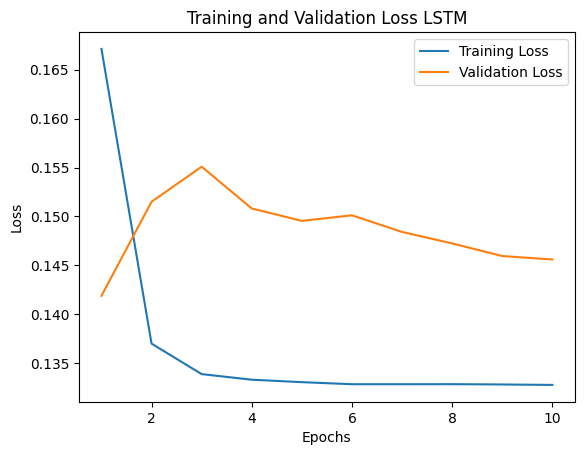

In [ ]:
import matplotlib.pyplot as plt
train_loss_lstm = history_lstm_borderline.history['loss']
val_loss_lstm = history_lstm_borderline.history['val_loss']
# Plot the loss curves
plt.plot(range(1, len(train_loss_lstm) + 1), train_loss_lstm, label='Training Loss')
plt.plot(range(1, len(val_loss_lstm) + 1), val_loss_lstm, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss LSTM')
plt.legend()
plt.show()

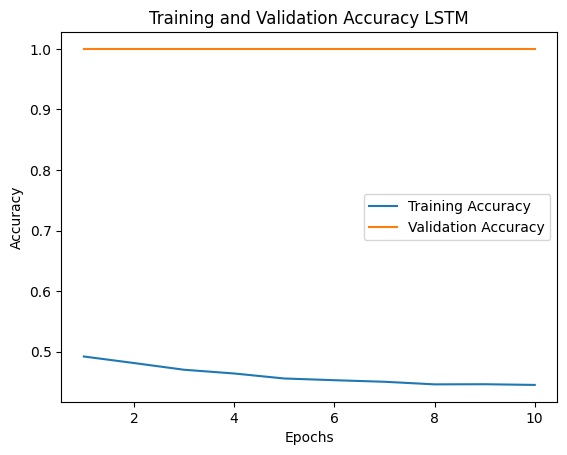

In [ ]:
import matplotlib.pyplot as plt
accuracy_lstm = history_lstm_borderline.history['accuracy']
val_accuracy_lstm = history_lstm_borderline.history['val_accuracy']
# Plot the loss curves
plt.plot(range(1, len(accuracy_lstm) + 1), accuracy_lstm, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_lstm) + 1), val_accuracy_lstm, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy LSTM')
plt.legend()
plt.show()

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step


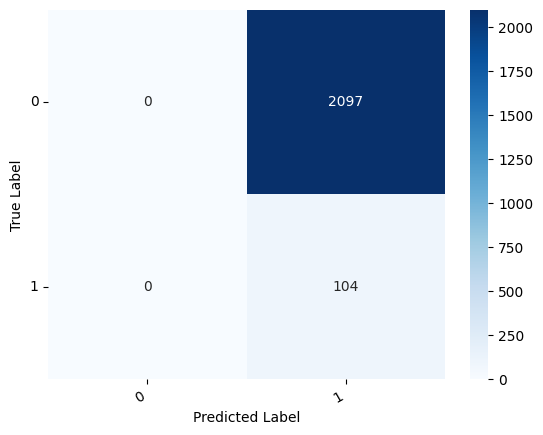

In [ ]:
predictions_lstm_1 = lstm_model.predict(x_test_padded1)
predicted_labels_lstm_1 = (predictions_lstm_1 > 0.5).astype(int)
cm_lstm_1 = confusion_matrix(y_test1,predicted_labels_lstm_1)
show_confusion_matrix(cm_lstm_1)

####KMeansSMOTE

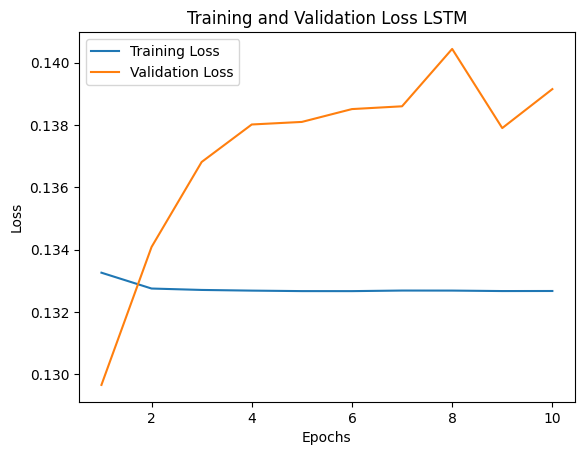

In [ ]:
import matplotlib.pyplot as plt
train_loss_lstm = history_lstm_kmeans.history['loss']
val_loss_lstm = history_lstm_kmeans.history['val_loss']
# Plot the loss curves
plt.plot(range(1, len(train_loss_lstm) + 1), train_loss_lstm, label='Training Loss')
plt.plot(range(1, len(val_loss_lstm) + 1), val_loss_lstm, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss LSTM')
plt.legend()
plt.show()

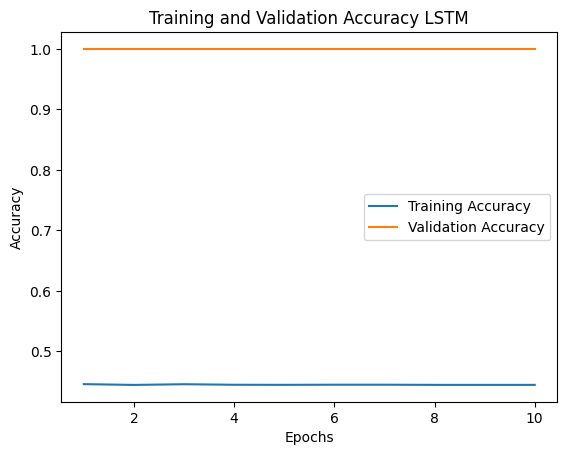

In [ ]:
import matplotlib.pyplot as plt
accuracy_lstm = history_lstm_kmeans.history['accuracy']
val_accuracy_lstm = history_lstm_kmeans.history['val_accuracy']
# Plot the loss curves
plt.plot(range(1, len(accuracy_lstm) + 1), accuracy_lstm, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_lstm) + 1), val_accuracy_lstm, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy LSTM')
plt.legend()
plt.show()

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step


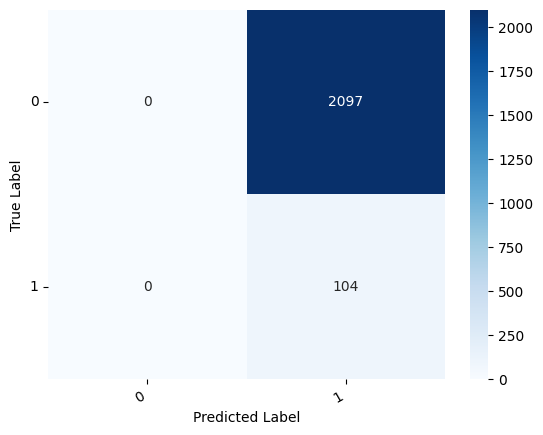

In [ ]:
predictions_lstm_1 = lstm_model.predict(x_test_padded1)
predicted_labels_lstm_1 = (predictions_lstm_1 > 0.5).astype(int)
cm_lstm_1 = confusion_matrix(y_test1,predicted_labels_lstm_1)
show_confusion_matrix(cm_lstm_1)

####SVMSMOTE

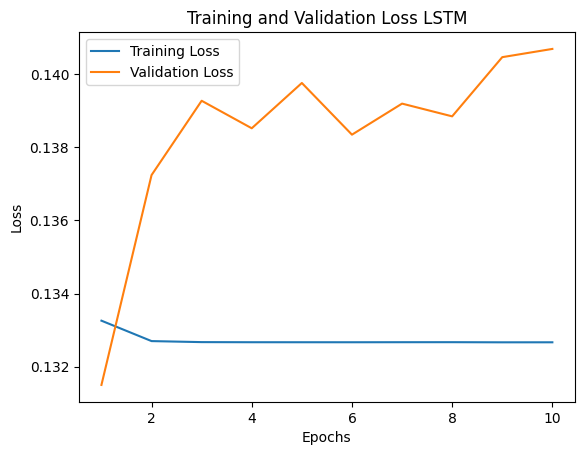

In [ ]:
import matplotlib.pyplot as plt
train_loss_lstm = history_lstm_svm.history['loss']
val_loss_lstm = history_lstm_svm.history['val_loss']
# Plot the loss curves
plt.plot(range(1, len(train_loss_lstm) + 1), train_loss_lstm, label='Training Loss')
plt.plot(range(1, len(val_loss_lstm) + 1), val_loss_lstm, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss LSTM')
plt.legend()
plt.show()

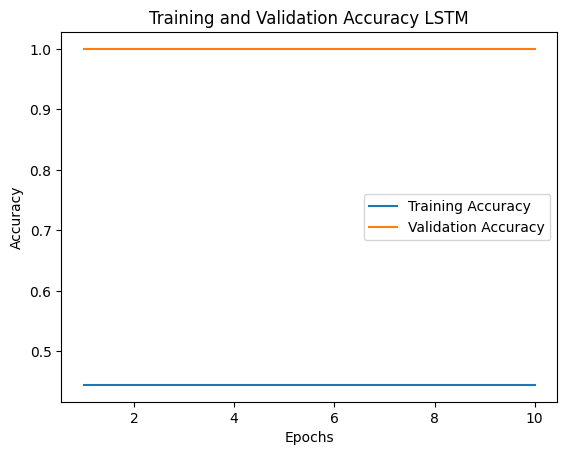

In [ ]:
import matplotlib.pyplot as plt
accuracy_lstm = history_lstm_svm.history['accuracy']
val_accuracy_lstm = history_lstm_svm.history['val_accuracy']
# Plot the loss curves
plt.plot(range(1, len(accuracy_lstm) + 1), accuracy_lstm, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy_lstm) + 1), val_accuracy_lstm, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy LSTM')
plt.legend()
plt.show()

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step


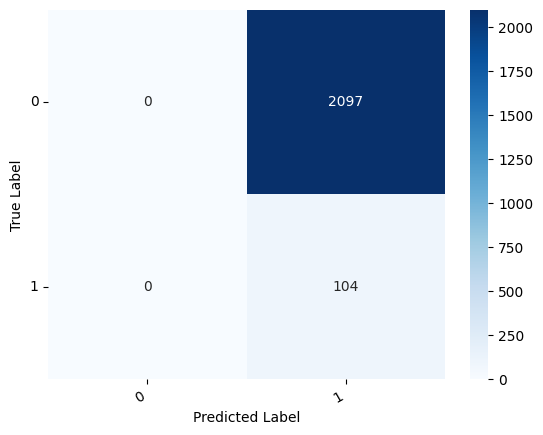

In [ ]:
predictions_lstm_1 = lstm_model.predict(x_test_padded1)
predicted_labels_lstm_1 = (predictions_lstm_1 > 0.5).astype(int)
cm_lstm_1 = confusion_matrix(y_test1,predicted_labels_lstm_1)
show_confusion_matrix(cm_lstm_1)